In [1]:
pip install ucimlrepo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
#loading the dataset
student_performance = fetch_ucirepo(id=320)

#defining features and targets
X = student_performance.data.features
y = student_performance.data.targets

# **Preprocessing**

```
# This is formatted as code
```



In [17]:
#defining numerical and categorical features
numerical_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

#splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y['G3'], test_size=0.2, random_state=42)

#preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

# **Modeling**

# Baseline Model

In [6]:
#baseline model
baseline_pred = np.ones(len(y_test)) * y_train.mean()
baseline_mse = mean_squared_error(y_test, baseline_pred)

print(f"Baseline Model MSE: {baseline_mse:.4f}")

Baseline Model MSE: 10.0653


# Linear Regression

In [7]:
#linear regression pipeline
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

#fitting into the pipeline
linear_pipeline.fit(X_train, y_train)
linear_train_preds = linear_pipeline.predict(X_train)
linear_test_preds = linear_pipeline.predict(X_test)

#errors
linear_train_mse = mean_squared_error(y_train, linear_train_preds)
linear_test_mse = mean_squared_error(y_test, linear_test_preds)

print(f"Linear Regression Train MSE: {linear_train_mse:.4f}")
print(f"Linear Regression Test MSE: {linear_test_mse:.4f}")


Linear Regression Train MSE: 6.4476
Linear Regression Test MSE: 8.1898


# Decision Trees

In [8]:
#defining the parameter grid for max_depth
param_grid = {'model__max_depth': [2, 3, 5, 7, 10, 15, 20, None]}

#creating the pipeline for preprocessing and the decision tree model
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

#using grid search cross validation to find the best max_depth
grid_search = GridSearchCV(
    estimator=tree_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

#fitting
grid_search.fit(X_train, y_train)

#extracting the best model and its parameters
best_tree = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

#evaluating the best decision tree model on train and test sets
best_train_preds = best_tree.predict(X_train)
best_test_preds = best_tree.predict(X_test)

best_train_mse = mean_squared_error(y_train, best_train_preds)
best_test_mse = mean_squared_error(y_test, best_test_preds)

print("\nDecision Tree Results")
print(f"Train MSE: {best_train_mse:.4f}")
print(f"Test MSE: {best_test_mse:.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'model__max_depth': 2}

Decision Tree Results
Train MSE: 7.6692
Test MSE: 8.5202


Text(0.5, 1.0, 'Decision Tree Visualization')

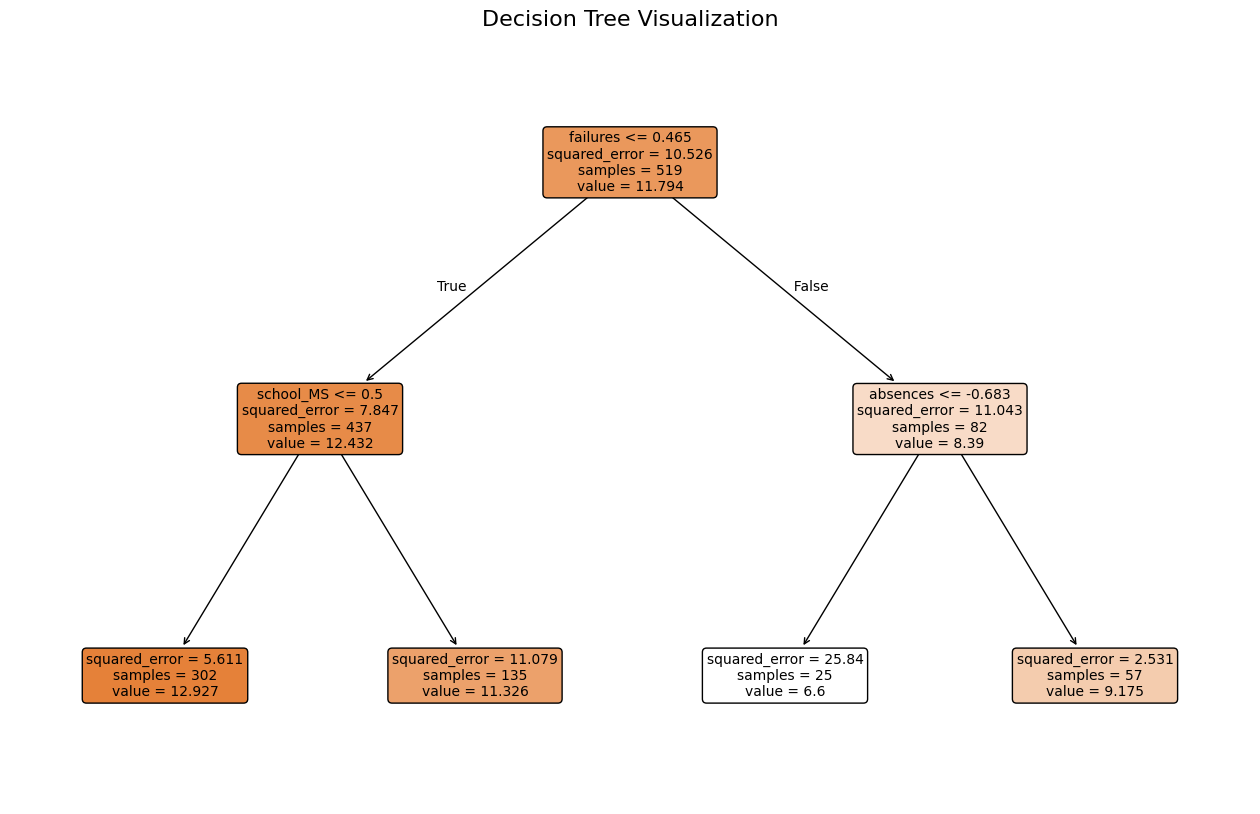

In [9]:
#visualizing the decision tree
from sklearn.tree import plot_tree

#combining numerical and categorical feature names
all_feature_names = numerical_features + list(
    preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
)

optimal_tree_model = best_tree.named_steps['model']

plt.figure(figsize=(16, 10))
plot_tree(
    optimal_tree_model,
    feature_names=all_feature_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization", fontsize=16)

<ipython-input-10-591e0b963449>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_df.head(5), palette="Blues_d")


            Feature  Importance
5          failures    0.760920
13        school_MS    0.161335
12         absences    0.077744
0               age    0.000000
29  guardian_mother    0.000000


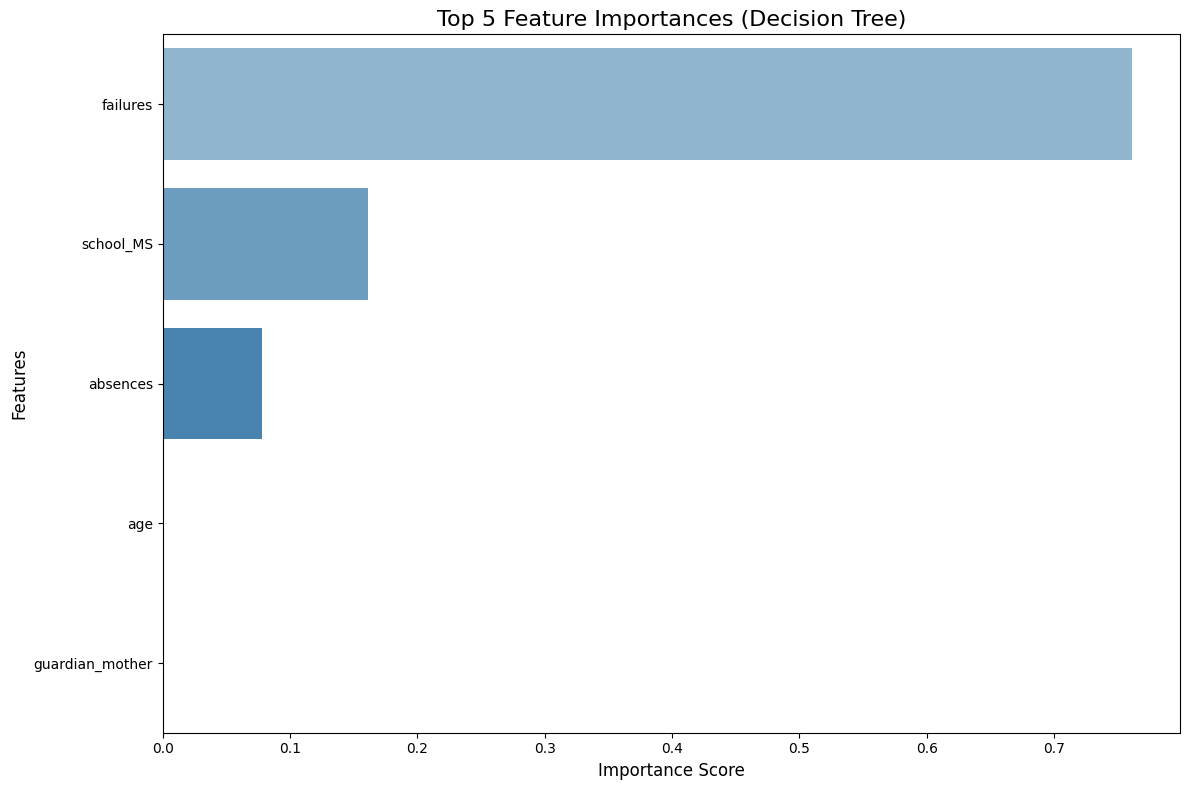

In [10]:
#extracting feature importance from the decision tree model
importances = optimal_tree_model.feature_importances_

#creating a data frame to visualize importances
importances_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

#plotting the importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(5), palette="Blues_d")
plt.title("Top 5 Feature Importances (Decision Tree)", fontsize=16)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()


print(importances_df.head(5))



# KNN

In [18]:
#defining the pipeline for preprocessing and KNN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor())
])

#defining the parameter grid for hyperparameter tuning
knn_params_uniform = {
    'model__n_neighbors': [3, 5, 7, 9, 11, 15, 19],
    'model__weights': ['uniform'],
    'model__p': [1, 2]
}

#performing grid search cross validationfor hyperparameter tuning
knn_grid_uniform = GridSearchCV(
    knn_pipeline, knn_params_uniform,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)


knn_grid_uniform.fit(X_train, y_train)

#getting the best model and its parameters
best_knn_model_uniform = knn_grid_uniform.best_estimator_
best_knn_params_uniform = knn_grid_uniform.best_params_

#evaluating the best KNN model on training and test data
knn_train_preds_uniform = best_knn_model_uniform.predict(X_train)
knn_test_preds_uniform = best_knn_model_uniform.predict(X_test)

knn_train_mse_uniform = mean_squared_error(y_train, knn_train_preds_uniform)
knn_test_mse_uniform = mean_squared_error(y_test, knn_test_preds_uniform)

print(f"Uniform Weighting Best KNN Parameters: {best_knn_params_uniform}")
print(f"Uniform KNN Train MSE: {knn_train_mse_uniform:.4f}")
print(f"Uniform KNN Test MSE: {knn_test_mse_uniform:.4f}")


Fitting 5 folds for each of 14 candidates, totalling 70 fits
Uniform Weighting Best KNN Parameters: {'model__n_neighbors': 11, 'model__p': 1, 'model__weights': 'uniform'}
Uniform KNN Train MSE: 6.6966
Uniform KNN Test MSE: 8.7810


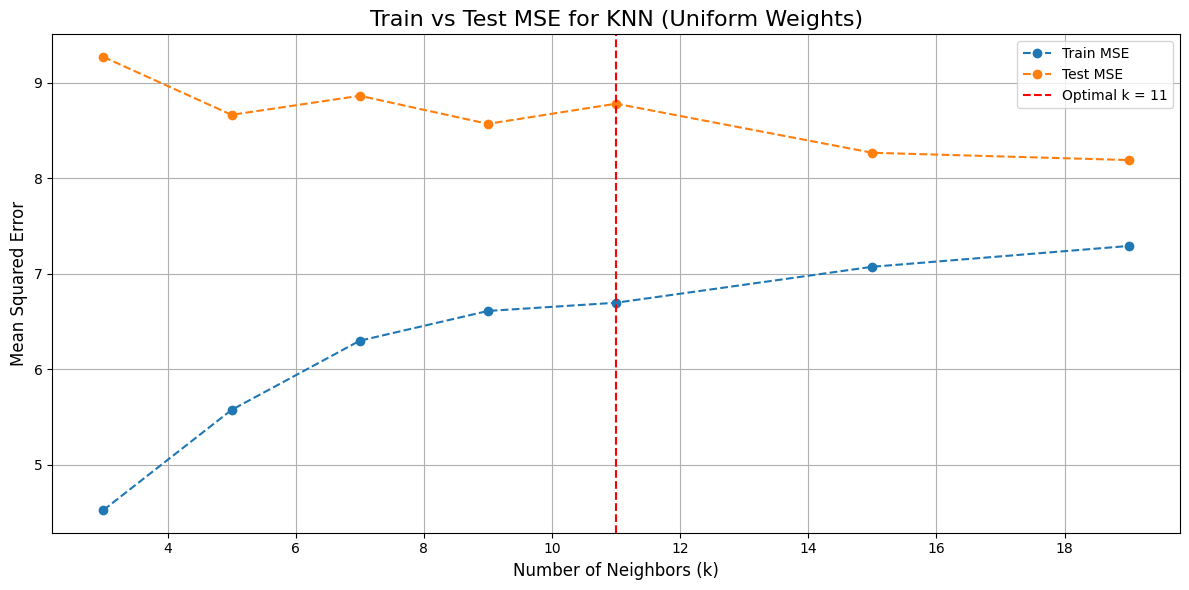

In [19]:
#defining a range of k values to test
k_values = [3, 5, 7, 9, 11, 15, 19]
train_mses = []
test_mses = []

#looping through k values and calculating MSE for train and test sets
for k in k_values:
    knn_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsRegressor(n_neighbors=k, weights='uniform', p=1))
    ])
    knn_model.fit(X_train, y_train)
    train_preds = knn_model.predict(X_train)
    test_preds = knn_model.predict(X_test)
    train_mses.append(mean_squared_error(y_train, train_preds))
    test_mses.append(mean_squared_error(y_test, test_preds))

#plotting the MSE graph
plt.figure(figsize=(12, 6))
plt.plot(k_values, train_mses, marker='o', label="Train MSE", linestyle='--')
plt.plot(k_values, test_mses, marker='o', label="Test MSE", linestyle='--')
plt.axvline(x=best_knn_params_uniform['model__n_neighbors'], color='r', linestyle='--', label=f"Optimal k = {best_knn_params_uniform['model__n_neighbors']}")
plt.xlabel("Number of Neighbors (k)", fontsize=12)
plt.ylabel("Mean Squared Error", fontsize=12)
plt.title("Train vs Test MSE for KNN (Uniform Weights)", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()


# Random Forest

In [20]:
#defining random forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

#defining the hyperparameter grid for random forest
rf_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
}

#using grid search cross validation for hyperparameter tuning
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='neg_mean_squared_error', verbose=1)
rf_grid.fit(X_train, y_train)

#getting the best random forest model and parameters
best_rf_model = rf_grid.best_estimator_
best_rf_params = rf_grid.best_params_

#evaluating the model on training and testing data
rf_train_preds = best_rf_model.predict(X_train)
rf_test_preds = best_rf_model.predict(X_test)

rf_train_mse = mean_squared_error(y_train, rf_train_preds)
rf_test_mse = mean_squared_error(y_test, rf_test_preds)

print(f"Best Random Forest Parameters: {best_rf_params}")
print(f"Random Forest Train MSE: {rf_train_mse:.4f}")
print(f"Random Forest Test MSE: {rf_test_mse:.4f}")



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Random Forest Parameters: {'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Random Forest Train MSE: 4.4641
Random Forest Test MSE: 7.8844


<ipython-input-21-58ddd2b67c2f>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_df.head(10), palette="Blues_d")


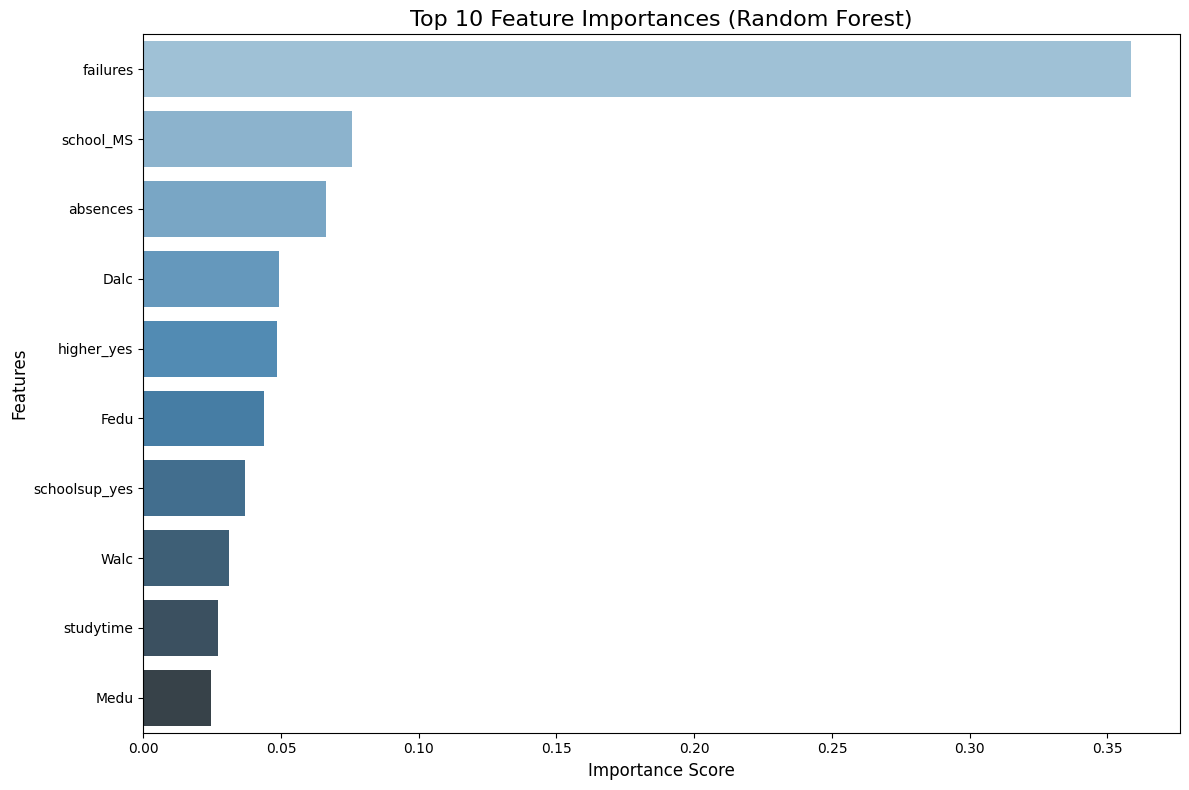

In [21]:
#feature importance plot for random forest
importances = best_rf_model.named_steps['model'].feature_importances_
feature_names = numerical_features + list(best_rf_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))

#creating data frame for visualization
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

#plotting the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(10), palette="Blues_d")
plt.title("Top 10 Feature Importances (Random Forest)", fontsize=16)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()



# Model Comparison

In [22]:
#creating dictionary with all the model results
model_results = {
    "Model": [
        "Linear Regression",
        "Decision Tree",
        "KNN (Uniform)",
        "Random Forest"
    ],
    "Train MSE": [6.4476, 7.6692, 6.6696, 4.4641],
    "Test MSE": [8.1898, 8.5202, 8.7810, 7.8844]
}

#converting the dictionary into a data frame
results_df = pd.DataFrame(model_results)


print(results_df)



               Model  Train MSE  Test MSE
0  Linear Regression     6.4476    8.1898
1      Decision Tree     7.6692    8.5202
2      KNN (Uniform)     6.6696    8.7810
3      Random Forest     4.4641    7.8844
